In [1]:
import numpy as np 
import glob 
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve
from AngioMorphPCA.io import Get_simple_vtk
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from AngioMorphPCA.compute_geometry import compute_curvature_and_torsion

def calculate_3d_curve_abscissas(curve):
    # 初始化长度列表，起始点的长度为0
    abscissas = [0]

    # 遍历曲线上的点，计算累积长度
    for i in range(1, len(curve)):
        # 计算当前点与前一个点之间的距离
        distance = np.linalg.norm(np.array(curve[i]) - np.array(curve[i-1]))
        # 将这个距离加到最后一个累积长度上，得到新的累积长度
        abscissas.append(abscissas[-1] + distance)

    return abscissas

def makeVtkFile(savePath, coords, scalarAttributes):
    v = open(savePath, "w+")
    v.write("# vtk DataFile Version 2.0\nVessel Segment\nASCII\nDATASET POLYDATA\nPOINTS {} float\n".format(len(coords)))
    for i in range(len(coords)):
        v.write("{} {} {}\n".format(coords[i,0], coords[i,1], coords[i,2]))

    v.write("LINES {} {}\n".format(1, len(coords)+1))
    v.write("{}".format(len(coords)))
    for i in range(len(coords)):
        v.write(" {}".format(i))
    v.write("\n")

    ####################################
    #        scalar Attributes         #
    ####################################

    if len(scalarAttributes) > 0:
        v.write("POINT_DATA {}\n".format(len(coords)))
        for i in range(len(scalarAttributes)):
            v.write("SCALARS {} {}\n".format(scalarAttributes[i][0], scalarAttributes[i][1]))
            v.write("LOOKUP_TABLE default\n")
            for j in range(len(coords)):
                    v.write("{}\n".format(scalarAttributes[i][2][j]))

    v.close()

    
def mkdir(super_path,testname):
    #dir_path = test_dir_path+"{}\\".format(testname)
    dir_path = super_path+"{}/".format(testname)
    if os.path.exists(dir_path)==False:
        #print("making new directory {}...".format(dir_path))
        os.mkdir(dir_path)
    # else:
    #     print("generating in directory {}...".format(dir_path))
    return dir_path

def remove_high_freq_components(data, freq_threshold):
    """
    使用傅立叶变换去除高频成分。
    
    参数:
    - data: 一维数组，输入数据。
    - freq_threshold: float，频率阈值，用于确定哪些频率成分被视为高频并需要被去除。
    
    返回:
    - filtered_data: 一维数组，滤波后的数据。
    """
    # 执行傅立叶变换
    data_fft = np.fft.fft(data)
    # 获取频率
    freq = np.fft.fftfreq(len(data))
    
    # 根据频率阈值滤除高频成分
    data_fft[np.abs(freq) > freq_threshold] = 0
    
    # 执行逆傅立叶变换
    filtered_data = np.fft.ifft(data_fft)
    
    # 返回实部，去除由于计算引入的虚部（应该接近于零）
    return filtered_data.real

def compute_centroid(curves):
    centroid = np.mean(curves, axis=0)
    return np.array(centroid)
def translate_to_centroid(curves):
    centroid = compute_centroid(curves)
    new_curves = []
    for i in range(len(curves)):
        new_curves.append(curves[i] - centroid)
    return np.array(new_curves)

d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)


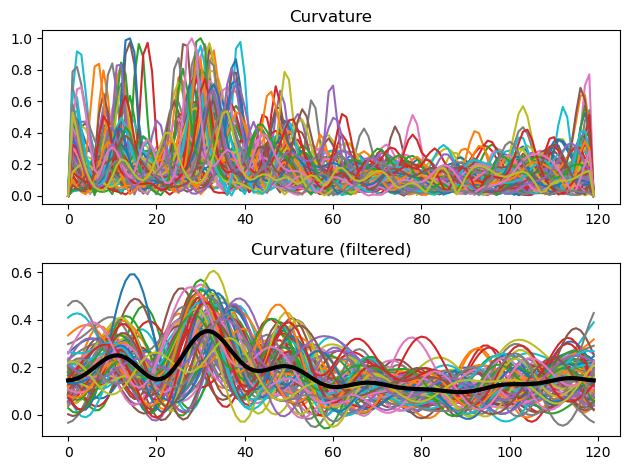

In [2]:


brava_files = glob.glob('../brava_ica_mirrored/*.vtk')
aneurisk_files = []
# aneurisk_files = glob.glob('../aneurisk_ica_mirrored/*.vtk')
total_files = brava_files + aneurisk_files
# np.save("total_files.npy", total_files)

resample_num=120


curvatures=[]
curves = []

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for i in range(len(total_files)):
    casename = total_files[i].split('\\')[-1].split('.')[0]
    temp = Get_simple_vtk(total_files[i])
    temp = translate_to_centroid(temp)
    temp_func = parameterize_curve(temp)
    t_resampled = np.linspace(0, 1, resample_num)
    resampled_curve = temp_func(t_resampled)
    curves.append(resampled_curve)
    c, t = compute_curvature_and_torsion(resampled_curve)
    ax1.plot(c, label=casename)
    fft_c = remove_high_freq_components(c, 0.06)
    ax2.plot(fft_c, label=casename)
    ax1.set_title('Curvature')
    ax2.set_title('Curvature (filtered)')
    # print (len(c), len(fft_c))
    curvatures.append(fft_c)
curvatures = np.array(curvatures)
average_curvature = np.mean(curvatures, axis=0)
ax2.plot(np.mean(curvatures, axis=0), label='Mean',linewidth=3, color='black')
plt.tight_layout()
plt.show()




In [19]:
import matplotlib.pyplot as plt

import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)

def plot_curve(curve, fmt="k", ax=None, add_origin=True):
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection="3d")

    if add_origin:
        curve = insert_zeros(curve, axis=-2)

    ax.plot(*[curve[:, k] for k in range(3)], fmt)
    ax.scatter(*[curve[0, k] for k in range(3)], fmt)
    return ax


def plot_geodesic(geod_points, ax=None, add_origin=True):
    n_times = geod_points.shape[0]
    k_sampling_points = geod_points.shape[-2] + 1

    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection="3d")

    if add_origin:
        geod_points = insert_zeros(geod_points, axis=-2)

    ax.plot(*[geod_points[0, :, k] for k in range(3)],  c="b", linewidth=2)
    ax.plot(*[geod_points[-1, :, k] for k in range(3)], c="r", linewidth=2)

    for i in range(1, n_times - 1):
        ax.plot(*[geod_points[i, :, k] for k in range(3)], c="k", linewidth=1)

    for j in range(k_sampling_points - 1):
        ax.plot(*[geod_points[:, j, k] for k in range(3)], c="k", linewidth=1)

    return ax


In [25]:
k_sampling_points = resample_num

curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=k_sampling_points, equip=False
)


# projection的作用是把两条curve都移动到origin
curve_a = curves_r3.projection(curves[0])
curve_b = curves_r3.projection(curves[6])

# normalize的作用是rescaling them to have unit length.
curve_a = curves_r3.normalize(curve_a)
curve_b = curves_r3.normalize(curve_b)

# 为curve_r3配备参数化不变度量
curves_r3.equip_with_metric(SRVMetric)

# 保持curve_a不变，对旋转和重参数化进行求商
curves_r3.equip_with_group_action("rotations and reparametrizations")
curves_r3.equip_with_quotient_structure()


curve_b_aligned = curves_r3.fiber_bundle.align(curve_b, curve_a)
print (curve_b_aligned.shape)
hgeod_fun = curves_r3.quotient.metric.geodesic(curve_a, curve_b)

n_times = 10
times = gs.linspace(0.0, 1.0, n_times)
hgeod = hgeod_fun(times)


(119, 3)


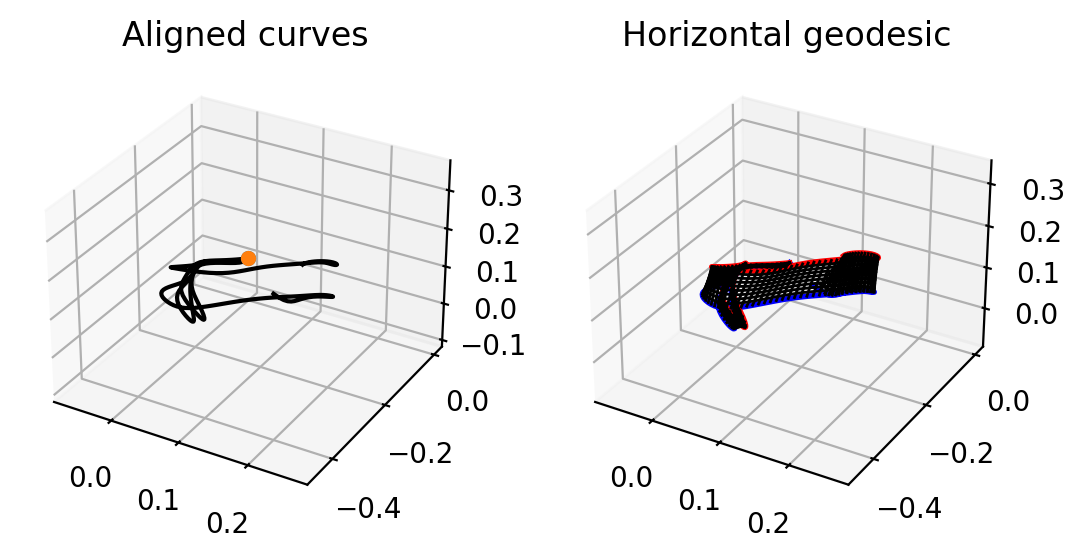

In [21]:
fig= plt.figure(dpi=200)
ax1 = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122,projection='3d')
plot_curve(curve_a, ax=ax1)
plot_curve(curve_b_aligned, ax=ax1)
ax1.set_title("Aligned curves")

plot_geodesic(hgeod, ax=ax2)
ax2.set_title("Horizontal geodesic")
plt.show()

In [22]:
parametrized_curve_a = parameterize_curve(curve_a)
parametrized_curve_b = parameterize_curve(curve_b)

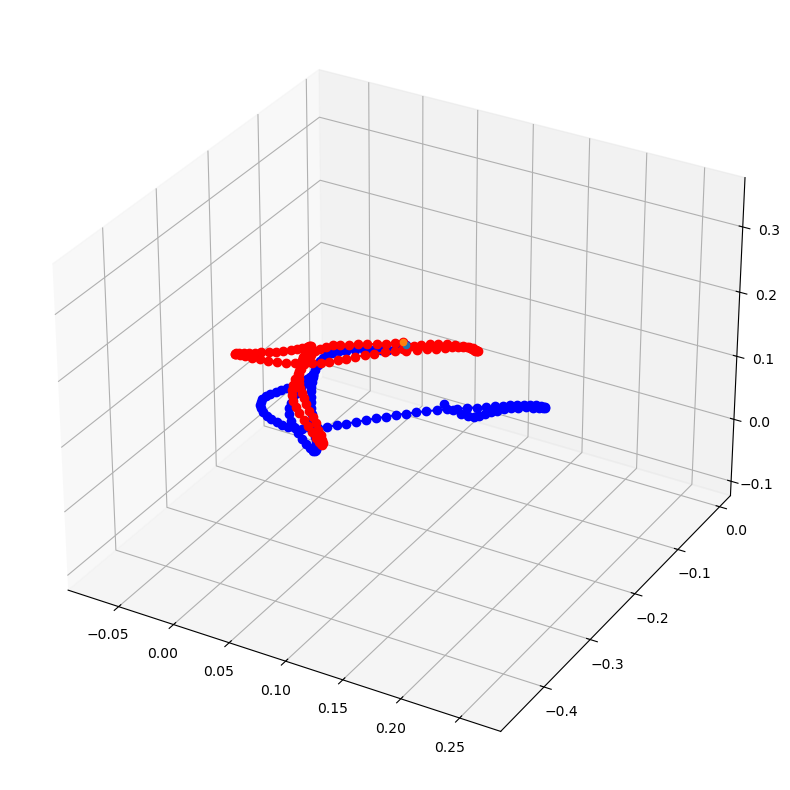

In [23]:
k_sampling_points = resample_num
sampling_points = gs.linspace(0.0, 1.0, k_sampling_points)

curve_a = parametrized_curve_a(sampling_points)
curve_b = parametrized_curve_b(sampling_points)

ax = plot_curve(curve_a, "o-b", add_origin=False)
plot_curve(curve_b, "o-r", ax=ax, add_origin=False)
plt.show()

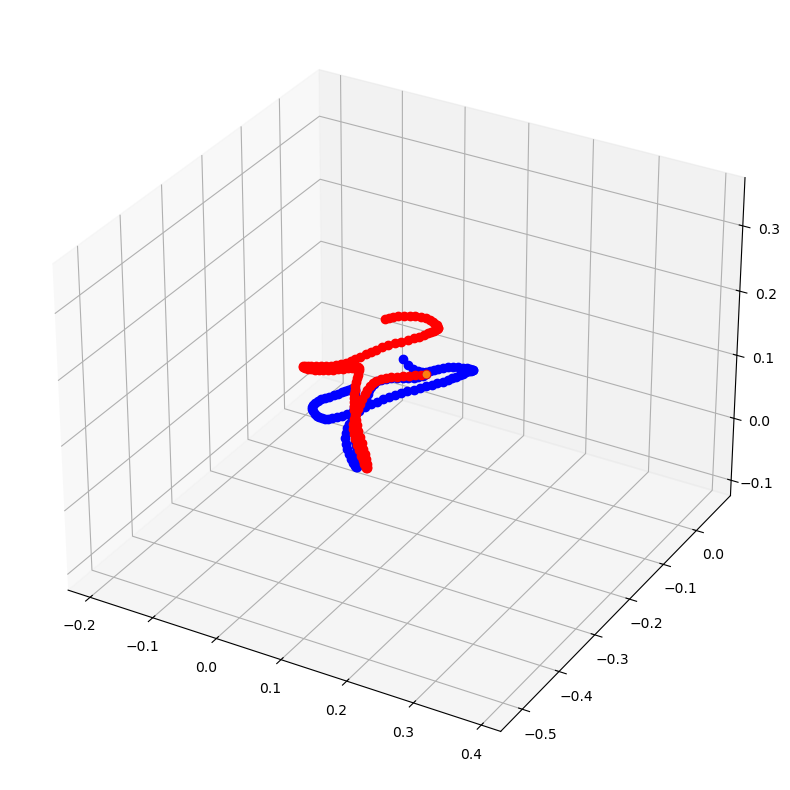

In [24]:
curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=k_sampling_points, equip=False
)

curve_a0 = curves_r3.projection(curve_a)
curve_b0 = curves_r3.projection(curve_b)

ax = plot_curve(curve_a0, "o-b")
plot_curve(curve_b0, "o-r", ax=ax)
plt.axis("equal")
plt.show()

In [9]:
curve_a_resampled = parametrized_curve_a(sampling_points**2)
curve_b_resampled = parametrized_curve_b(sampling_points**2)

curve_a0_resampled = curves_r3.projection(curve_a_resampled)
curve_b0_resampled = curves_r3.projection(curve_b_resampled)

# curves_r3.metric.dist(curve_a0_resampled, curve_b0_resampled)

0.4734472057123575


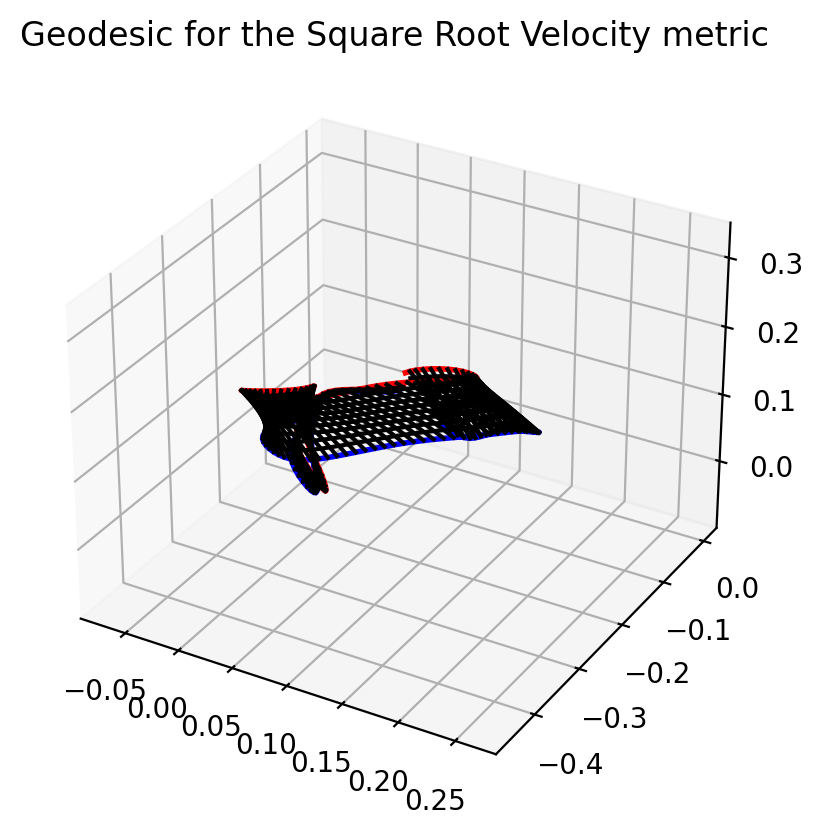

In [10]:
curves_r3.equip_with_metric(SRVMetric)

print (curves_r3.metric.dist(point_a=curve_a0, point_b=curve_b0))

geod_fun = curves_r3.metric.geodesic(curve_a0, curve_b0)

n_times = 10
times = gs.linspace(0.0, 1.0, n_times)
geod = geod_fun(times)
translation = gs.linspace(curve_a[0], curve_b[0], n_times)


fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection="3d")
plot_geodesic(geod, ax=ax, add_origin=True)
plt.title("Geodesic for the Square Root Velocity metric")
plt.show()

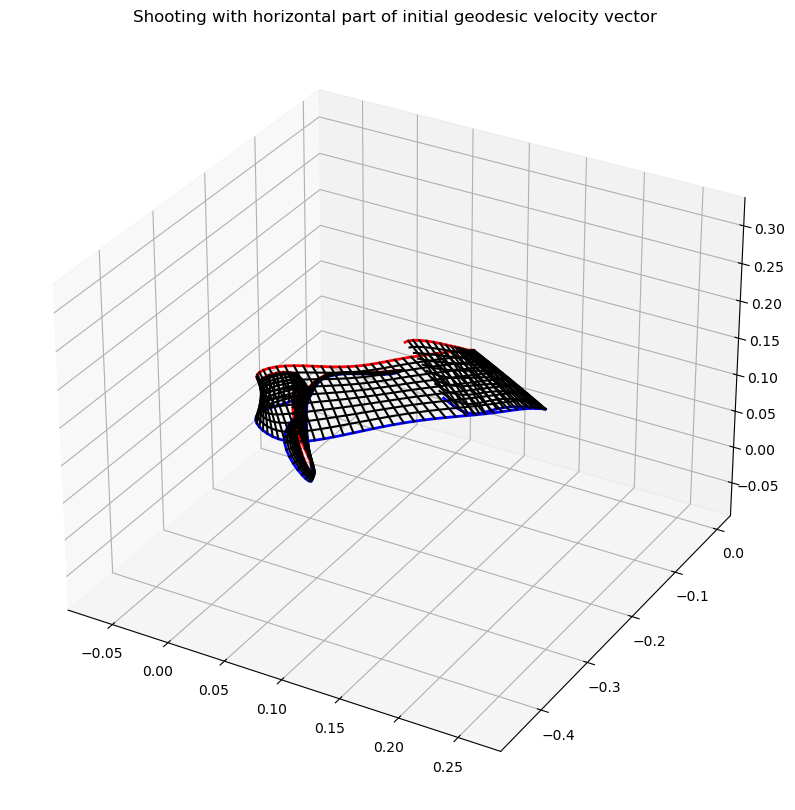

In [11]:
curves_r3.equip_with_group_action("reparametrizations")
curves_r3.equip_with_quotient_structure()

geod_velocity = (n_times - 1) * (geod[1:] - geod[:-1])

bundle = curves_r3.fiber_bundle
geod_velocity_hor = bundle.horizontal_projection(geod_velocity, geod[:-1])
geod_velocity_ver = bundle.vertical_projection(geod_velocity, geod[:-1])

shooted_geod_fun = curves_r3.metric.geodesic(
    initial_point=curve_a0, initial_tangent_vec=geod_velocity_hor[0]
)
shooted_geod = shooted_geod_fun(times)

plot_geodesic(shooted_geod)
plt.title("Shooting with horizontal part of initial geodesic velocity vector")
plt.show()

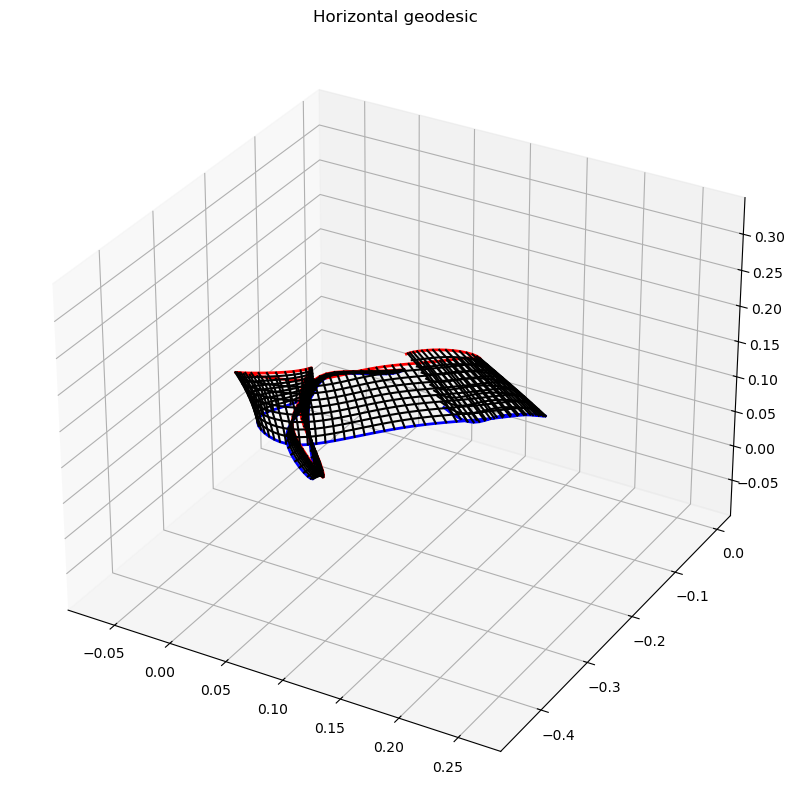

In [12]:
hgeod_fun = curves_r3.quotient.metric.geodesic(curve_a0, curve_b0)
hgeod = hgeod_fun(times)

plot_geodesic(hgeod)
plt.title("Horizontal geodesic")
plt.show()

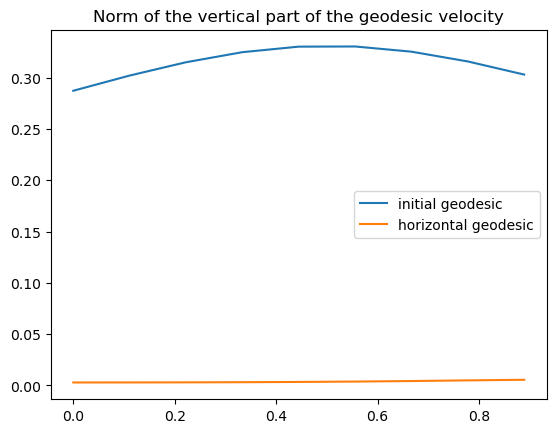

In [13]:
geod_vertical_norm = curves_r3.metric.norm(geod_velocity_ver, geod[:-1])

hgeod_velocity = (n_times - 1) * (hgeod[1:] - hgeod[:-1])
hgeod_velocity_ver = curves_r3.fiber_bundle.vertical_projection(
    hgeod_velocity, hgeod[:-1]
)
hgeod_vertical_norm = curves_r3.metric.norm(hgeod_velocity_ver, hgeod[:-1])

plt.figure()
plt.plot(times[:-1], geod_vertical_norm, label="initial geodesic")
plt.plot(times[:-1], hgeod_vertical_norm, label="horizontal geodesic")
plt.legend()
plt.title("Norm of the vertical part of the geodesic velocity")
plt.show()

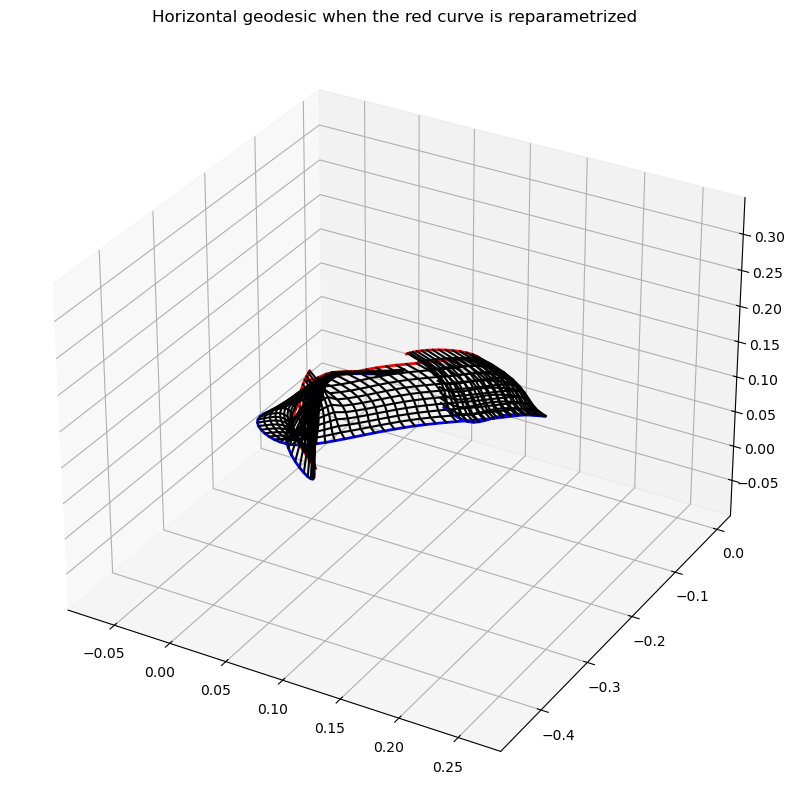

In [14]:
hgeod_fun = curves_r3.quotient.metric.geodesic(curve_a0, curve_b0_resampled)
hgeod = hgeod_fun(times)

plot_geodesic(hgeod)
plt.title("Horizontal geodesic when the red curve is reparametrized")
plt.show()

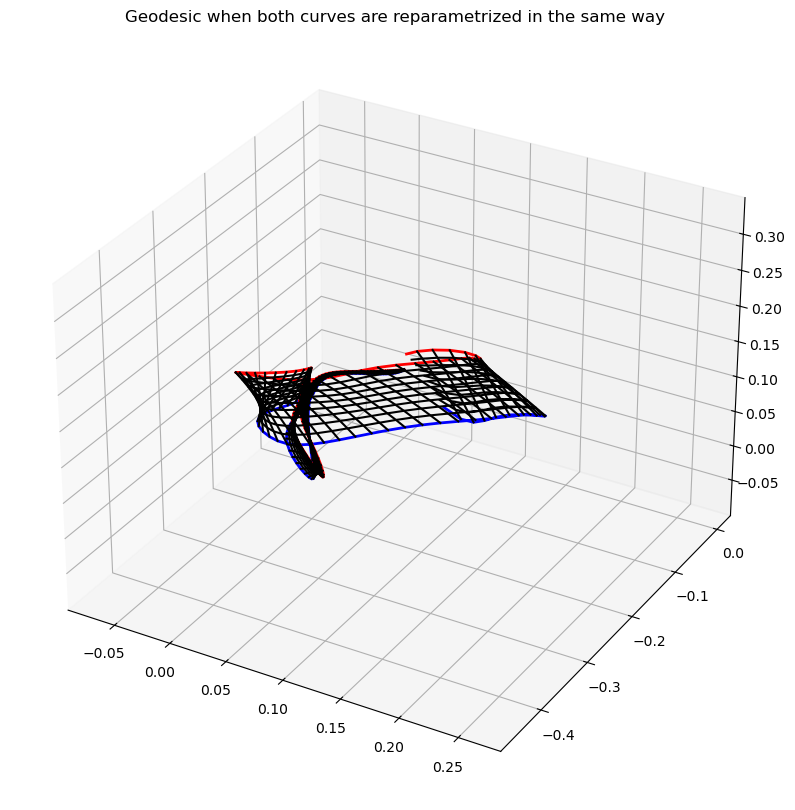

In [15]:
geod_fun_1 = curves_r3.metric.geodesic(curve_a0_resampled, curve_b0_resampled)
geod_1 = geod_fun_1(times)

plot_geodesic(geod_1)
plt.title("Geodesic when both curves are reparametrized in the same way")
plt.show()

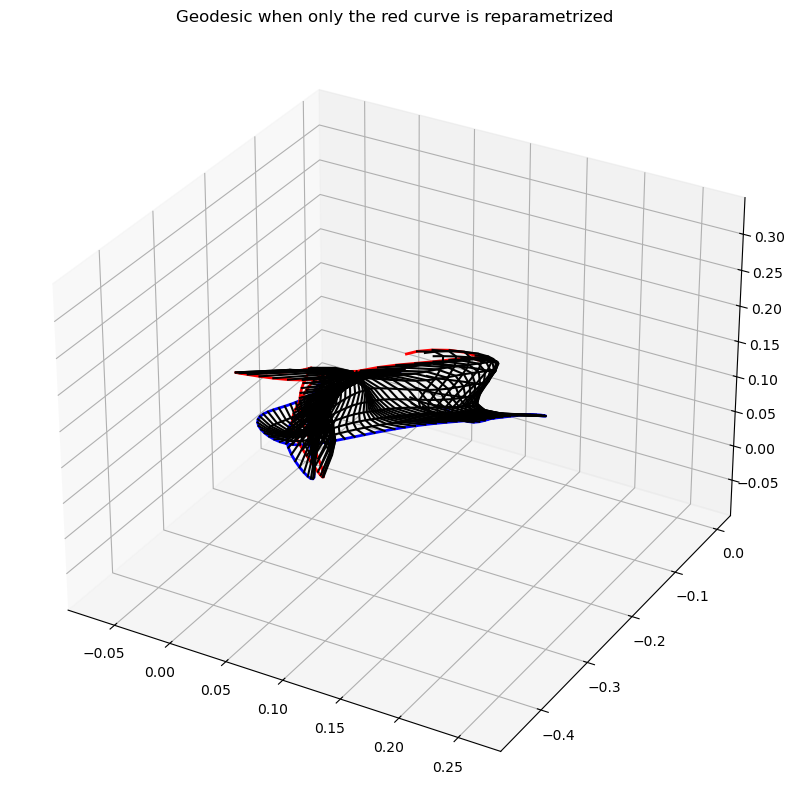

In [16]:
curves_r3.metric.dist(curve_a0, curve_b0_resampled)

geod_fun_2 = curves_r3.metric.geodesic(curve_a0, curve_b0_resampled)
geod_2 = geod_fun_2(times)

plot_geodesic(geod_2)
plt.title("Geodesic when only the red curve is reparametrized")
plt.show()

In [17]:
print(curves_r3.quotient.metric.dist(curve_a0, curve_b0))

print(curves_r3.quotient.metric.dist(curve_a0_resampled, curve_b0))
print(curves_r3.quotient.metric.dist(curve_a0, curve_b0_resampled))

0.30305857125253516
0.8232573060169688


0.9146402165283815


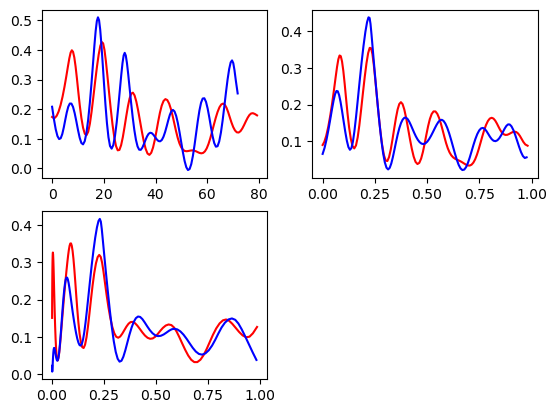

In [18]:
fig = plt.figure()
# 子图的数量
n_subplots = 4
# 创建一个空列表来存储子图的引用
axes = []

ablist = [[curves[0], curves[65]],
    [curve_a0,curve_b0], 
    [curve_a0_resampled, curve_b0_resampled]]

for i in range(len(ablist)):
    ax = fig.add_subplot(2, 2, i+1)
    axes.append(ax)
    ab = ablist[i]
    a = ab[0]
    b = ab[1]
    abiscissas_a = calculate_3d_curve_abscissas(a)
    abiscissas_b = calculate_3d_curve_abscissas(b)
    if i == 0:
        k = 1
    else:
        k = 100
    ca,_ = compute_curvature_and_torsion(a*k)
    cb,_ = compute_curvature_and_torsion(b*k)
    ca = remove_high_freq_components(ca,0.06)
    cb = remove_high_freq_components(cb,0.06)
    ax.plot(abiscissas_a,ca,color="r")
    ax.plot(abiscissas_b,cb,color="b")

plt.show()